# Load Packages 

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pyLDAvis
import pyLDAvis.gensim 
from pprint import pprint

import datetime

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from wordcloud import WordCloud
from unidecode import unidecode

import re
from langdetect import detect

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Load Data
- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

In [23]:
calendar = pd.read_csv("./Data/calendar.csv")
listings = pd.read_csv("./Data/listings.csv")
reviews = pd.read_csv("./Data/reviews.csv")

In [15]:
# size of the data
print("data size of calendar: ",calendar.shape) #price and availability for 3,818 listings in one year(365d)
print("data size of listings: ",listings.shape) 
print("data size of reviews: ",reviews.shape)

data size of calendar:  (1393570, 4)
data size of listings:  (3818, 92)
data size of reviews:  (84849, 6)


### calendar

In [16]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [17]:
print("Date range is from {} to {}" .format(calendar.date.min(),calendar.date.max()))

Date range is from 2016-01-04 to 2017-01-02


### listings

In [18]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [19]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

### reviews

In [20]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


# Question 1
####  What are the busiest times to visit Seattle? By how much do prices increase?

In [29]:
# data wrangling
calendar[['price']] = calendar[['price']].replace({r'\$': '', ',': ''},regex=True)
calendar[['price']] = calendar[['price']].astype(float)
calendar['date'] = pd.to_datetime(calendar['date'])

calendar['Month'] = calendar['date'].apply(lambda time: time.month)
calendar['Day of Week'] = calendar['date'].apply(lambda time: time.dayofweek)

In [30]:
print('Average listing price throughout the whole year: $',int(calendar[calendar.available=='t']['price'].mean()))

Average listing price throughout the whole year: $ 137


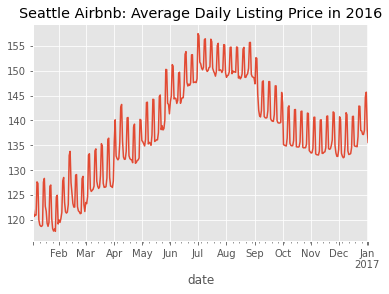

In [31]:
calendar[calendar.available=='t'].groupby(['date']).mean()['price'].plot();
plt.title('Seattle Airbnb: Average Daily Listing Price in 2016');

- The peak season is from June to August.

In [38]:
price_diff = calendar[calendar.available=='t'].groupby(['Month']).mean()['price']-calendar[calendar.available=='t']['price'].mean()

price_change = price_diff/calendar[calendar.available=='t']['price'].mean()*100

print("Average increase in each month (compared to the average price):")

pd.DataFrame(price_change).rename(columns={'price':'price change (pct)'})

Average increase in each month (compared to the average price):


,price change (pct)
Month,
1,-10.897602
2,-9.895934
3,-6.742093
4,-2.064487
5,1.155044
6,6.907310
7,10.257208
8,9.215085
9,3.850154


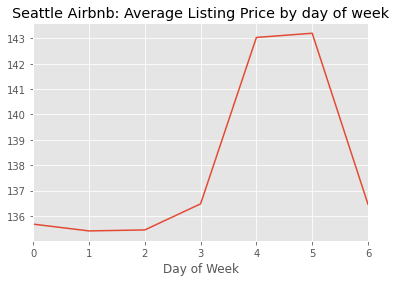

In [39]:
calendar[calendar.available=='t'].groupby(['Day of Week']).mean()['price'].plot();
plt.title('Seattle Airbnb: Average Listing Price by day of week');

- Friday and Saturday are obviously the busiest.

In [42]:
price_diff = calendar[calendar.available=='t'].groupby(['Day of Week']).mean()['price']-calendar[calendar.available=='t']['price'].mean()

price_change = price_diff/calendar[calendar.available=='t']['price'].mean()*100

print("Average increase in weekday (compared to the average price):")

pd.DataFrame(price_change).rename(columns={'price':'price change (pct)'}).reset_index()

Average increase in weekday (compared to the average price):


,Day of Week,price change (pct)
0,0,-1.644458
1,1,-1.838484
2,2,-1.810128
3,3,-1.064793
4,4,3.690921
5,5,3.811144
6,6,-1.076457


# Question 2
#### What are the common types of property in Seattle? How do the prices of common property differ in neighborhoods during peak periods?

In [252]:
listings.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

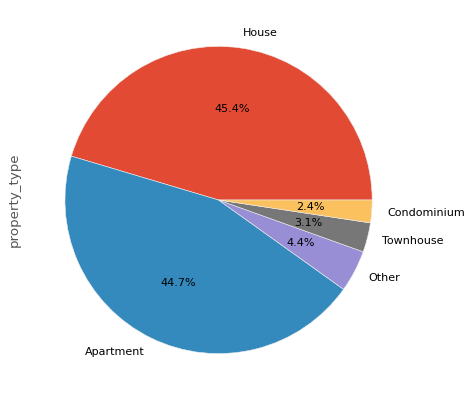

In [272]:
listings1=listings.copy()
common_property = ['House','Apartment','Townhouse','Condominium']
listings1[['property_type']] = listings1['property_type'].apply(lambda x: 'Other' if x not in common_property else x)
listings1.property_type.value_counts().plot(kind='pie',autopct='%1.1f%%');

In [44]:
# top 10 neighbourhoods
listings.neighbourhood_cleansed.value_counts().head(10) #87 in total

Broadway                     397
Belltown                     234
Wallingford                  167
Fremont                      158
Minor                        135
University District          122
Stevens                      119
First Hill                   108
Central Business District    103
Lower Queen Anne              94
Name: neighbourhood_cleansed, dtype: int64

In [45]:
# merge two dataset: calendar and listings
df = pd.merge(calendar, listings[['id','neighbourhood_cleansed','property_type']],how='inner',
              left_on='listing_id',right_on='id')

In [46]:
df.head()

,listing_id,date,available,price,Month,Day of Week,id,neighbourhood_cleansed,property_type
0,241032,2016-01-04,t,85.0,1,0,241032,West Queen Anne,Apartment
1,241032,2016-01-05,t,85.0,1,1,241032,West Queen Anne,Apartment
2,241032,2016-01-06,f,NaN,1,2,241032,West Queen Anne,Apartment
3,241032,2016-01-07,f,NaN,1,3,241032,West Queen Anne,Apartment
4,241032,2016-01-08,f,NaN,1,4,241032,West Queen Anne,Apartment


In [62]:
# Average daily house price by neighborhood in the busiest months (July and Aug.)
df1 = df[df['Month'].isin([7,8])&df['property_type'].isin(['House'])&(df.available=='t')]
df1.groupby(['neighbourhood_cleansed','property_type']).mean()['price'].sort_values()

neighbourhood_cleansed  property_type
Olympic Hills           House             76.623003
Georgetown              House             77.486486
Rainier Beach           House             77.767123
Mid-Beacon Hill         House             80.764317
Victory Heights         House             83.408000
                                            ...    
Alki                    House            268.749245
Brighton                House            279.666667
West Queen Anne         House            303.573604
Portage Bay             House            317.467456
East Queen Anne         House            405.410802
Name: price, Length: 79, dtype: float64

In [63]:
# Average daily apartment price by neighborhood in the busiest months (July and Aug.)
df2 = df[df['Month'].isin([7,8])&df['property_type'].isin(['Apartment'])&(df.available=='t')]
df2.groupby(['neighbourhood_cleansed','property_type']).mean()['price'].sort_values()

neighbourhood_cleansed     property_type
Dunlap                     Apartment         42.500000
South Delridge             Apartment         60.000000
Matthews Beach             Apartment         65.468750
Seward Park                Apartment         75.611111
Riverview                  Apartment         78.225806
                                               ...    
Crown Hill                 Apartment        217.500000
Pike-Market                Apartment        243.659379
Central Business District  Apartment        260.431039
Belltown                   Apartment        265.975045
Southeast Magnolia         Apartment        296.225806
Name: price, Length: 78, dtype: float64

# Question 3
#### On average how many days are the listings available? Is there any trend that exists?

In [64]:
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings.host_since.max() #no new host enters the market in this dataset.

Timestamp('2016-01-03 00:00:00')

In [65]:
print('Average available days:', int(listings['availability_365'].mean()))

Average available days: 244


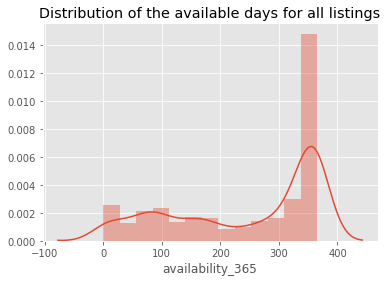

In [66]:
sns.distplot(listings.availability_365);
plt.title('Distribution of the available days for all listings');

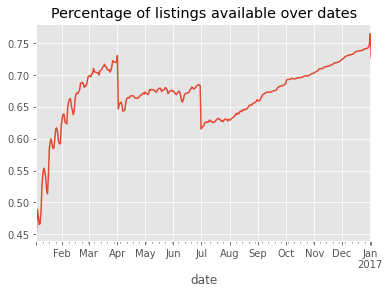

In [67]:
calendar1 = calendar.copy()
calendar1[['available']] = calendar1['available'].apply(lambda x: 1 if x=='t' else 0)
calendar1.groupby(['date']).mean()['available'].plot();
plt.title('Percentage of listings available over dates');

- The number of available listings increases over time, but it is relatively low in summer. 

# Question 4
#### What are the key topics based on the reviews? 

In [69]:
# merge two dataset: review and listings
df_review = pd.merge(reviews, listings[['id','review_scores_rating']],how='inner',
              left_on='listing_id',right_on='id')
df_review = df_review[['comments','review_scores_rating']]

In [70]:
df_review.head()

,comments,review_scores_rating
0,Cute and cozy place. Perfect location to every...,95.0
1,Kelly has a great room in a very central locat...,95.0
2,"Very spacious apartment, and in a great neighb...",95.0
3,Close to Seattle Center and all it has to offe...,95.0
4,Kelly was a great host and very accommodating ...,95.0


In [71]:
df_review.isnull().mean()

comments                0.000212
review_scores_rating    0.000236
dtype: float64

In [72]:
# drop missing values
df_review.dropna(how='any',inplace=True)

,review_scores_rating
count,84811.000000
mean,94.896523
std,4.084888
min,20.000000
25%,93.000000
50%,96.000000
75%,98.000000
max,100.000000


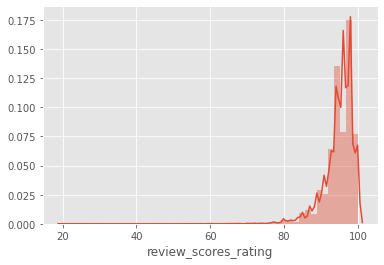

In [76]:
sns.distplot(df_review['review_scores_rating']);
df_review.describe()

In [85]:
# languages of the comments
def language_detection(text):
    try:
        return detect(text)
    except:
        return None
    
df_review['language'] = df_review['comments'].apply(language_detection)
df_review.language.value_counts().head(10)

en       83757
fr         239
de         213
zh-cn      161
es          81
ko          50
ro          43
nl          38
ja          29
pt          26
Name: language, dtype: int64

- Most reviews are written in English, so I will only analyze the English reviews in the following part.

In [86]:
df_review = df_review[df_review.language=='en']

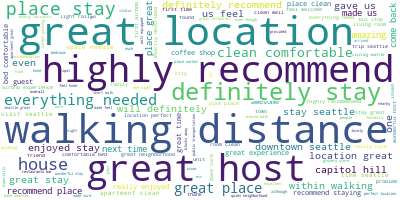

In [87]:
# WordCloud
# A quick look at the most frequent words

long_string = ','.join(list(df_review.comments.values))
long_string = long_string.lower()

#Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=10, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Clean Data

In [88]:
# convert to list
data=df_review.comments.values.tolist()
    
# remove unicode.
data=[unidecode(sent) for sent in data]

# remove punctuation
data=[re.sub(r"\"|\.|\?|\!|\,|\_|\(|\)|\{|\}|\/|\=|\+|\:|\;", "", sent) for sent in data]

# remove numbers 
data=[re.sub(r"\d", "", sent) for sent in data]

# remove new line character
data=[re.sub(r'\s+', ' ', sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations 

data_words = list(sent_to_words(data))

print(data_words[:1])

[['cute', 'and', 'cozy', 'place', 'perfect', 'location', 'to', 'everything']]


In [89]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['cute', 'and', 'cozy', 'place', 'perfect', 'location', 'to', 'everything']


In [90]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): 
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [91]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

#Do lemmatization keeping only noun, adj
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])

print(data_lemmatized[:1])

[['cute', 'cozy', 'place', 'perfect', 'location']]


### Create Dictionary and Corpus for Topic Modeling

In [92]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [93]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('cozy', 1), ('cute', 1), ('location', 1), ('perfect', 1), ('place', 1)]]

### Build the Topic Model
- alpha and eta are hyperparameters that affect sparsity of the topics.
- chunksize is the number of documents to be used in each training chunk.
- update_every determines how often the model parameters should be updated
- passes is the total number of training passes

In [102]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [109]:
# Print the Keyword in the 4 topics
# The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics(num_words=6))
doc_lda = lda_model[corpus]

[(0,
  '0.070*"great" + 0.057*"place" + 0.035*"apartment" + 0.032*"host" + '
  '0.032*"comfortable" + 0.032*"location"'),
 (1,
  '0.047*"amazing" + 0.044*"view" + 0.038*"able" + 0.034*"studio" + '
  '0.033*"spot" + 0.031*"family"'),
 (2,
  '0.043*"good" + 0.035*"home" + 0.024*"night" + 0.024*"little" + 0.024*"day" '
  '+ 0.021*"city"'),
 (3,
  '0.051*"bed" + 0.030*"bathroom" + 0.022*"guest" + 0.022*"small" + '
  '0.018*"people" + 0.016*"kitchen"')]


- The four topics are related to location, view, comfort(feel like home) and interior.

### Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [111]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.588555465760934

Coherence Score:  0.5053999816519235


In [112]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,sort_topics=False)
vis

/Users/jiahuili/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.414280  0.024142       1        1  54.210377
1     -0.143049  0.116579       2        1   8.827936
2     -0.115380 -0.376971       3        1  23.274254
3     -0.155852  0.236249       4        1  13.687431, topic_info=     Category          Freq      Term         Total  loglift  logprob
9     Default  53343.000000     great  53343.000000   30.000  30.0000
4     Default  43329.000000     place  43329.000000   29.000  29.0000
36    Default  13981.000000      good  13981.000000   28.000  28.0000
163   Default   9823.000000       bed   9823.000000   27.000  27.0000
147   Default  11303.000000      home  11303.000000   26.000  26.0000
...       ...           ...       ...           ...      ...      ...
178    Topic4   1194.529541  peaceful   1195.346191    1.988  -5.0821
1014   Topic4   1159.464478  basement   1160.260864    1.988  -5.1119
372    Topic4   1158.703125    detail   1159.510620    1.988  -5.1126
381    Topic4   1171.963379       tea   1172.787231    1.988  -5.1012
1146   Topic4   1159.620728     front   1160.436768    1.988  -5.1118

[156 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
214       2  0.999890       able
761       2  0.999674   accurate
105       2  0.999869    amazing
560       3  0.999786    amenity
15        1  0.999988  apartment
...     ...       ...        ...
65        3  0.999533    weekend
347       3  0.999865       well
400       4  0.999465     window
95        1  0.999909  wonderful
187       3  0.999733       work

[131 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])